# Model Experimentation and Iteration for Semantic Segmentation of the M2NIST Dataset

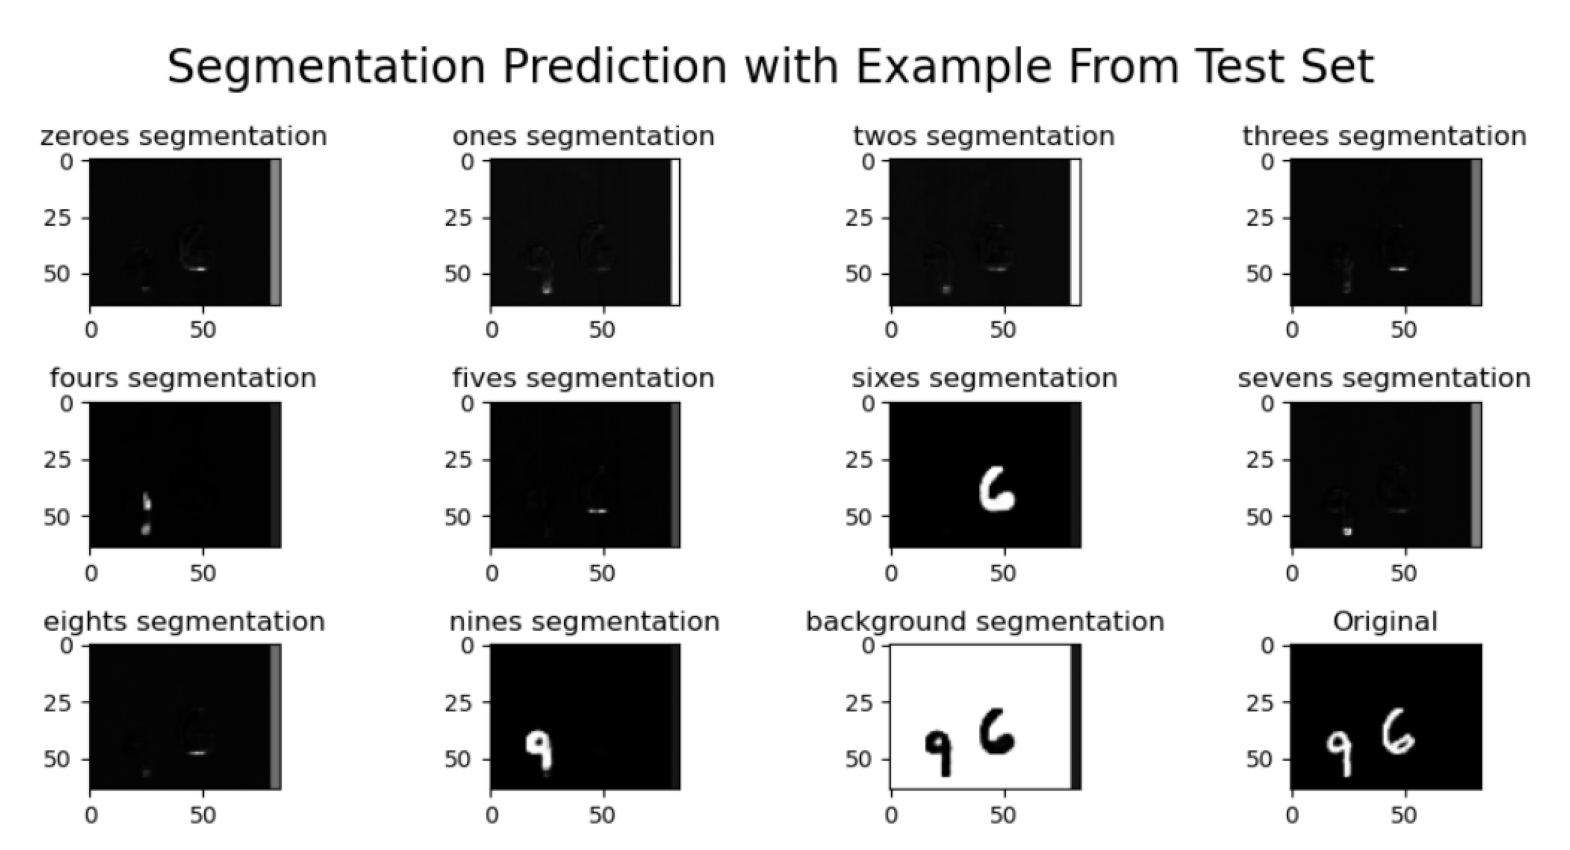

In [5]:
image_path = 'C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Machine Learning Learning\\Semantic Segmentation\\Git Folder\\Results.PNG'
img = mpimg.imread(image_path)
fig = plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off') 
plt.show()

# Writeup:

This notebook contains the model implementations of a Fully Convolutional Network trained to perform semantic segmentation on the M2NIST dataset. 

Featured above is a plot of the most successful model's performance of this task.

Semantic Segmentation is an image classification task where the goal is to classify every pixel of each class within an image to a color that represents that class. 

The Dataset:   
The M2NIST dataset is a superset of the MNIST dataset. The MNIST contains 2D grayscale images of handwritten digits in the shape of (28, 28). The M2NIST contains 2D grayscale images of shape (64, 84), each containing two (28, 28) MNIST digits superimposed into that larger dimmension. There are 5000 of these images, making the examples of the dataset have the shape(5000, 64, 84). The targets of the dataset are of shape (5000, 64, 84, 11). That fourth dimmension refers to 11 channels that each pertain to a segmentation channel of the 11 classes. Those classes are: the digits 0-9, as well as the background. If a randomly picked example contains a 5 and a 7 in the image, its training target would have a 5 colored in on the 5 channel in white, a 7 colored in on the 7 channel in white, and the background channel colored in white everywhere except the location of the digits. The goal of training is to take the (Batch, 64, 84) tensor and map it to a (Batch, 64, 84, 11) tensors with the properties just outlined.

The dataset was sourced from this kaggle page by FARHANHUBBLE: https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist

The Model: The type of model used in training is a Fully Convolutional Neural Network. In traditional CNN classification, dogs vs cat jpegs for example, jpegs are input into the net and are downscaled spatially while feature maps of the image increase with network depth. Then once dimmensionality of the image has been reduced to a significant enough degree, the image is fed into a dense layer for classification. Although semantic segmentation is a classifcation task, this method will not work for it. It would be far too complicated to create 64x84x11=59136 different classifiers for every pixel of the combined segmentation channels. Instead, we can discard the dense layers at the end of the net and use a convolutional layer that outputs the intended shape (64, 84, 11). This way, all pixel classifcation is done in parrelel and output into a single tensor. The Fully Convolutional Network is the driving idea behind all implementations tested in this project.

With the FCN in mind, we add the concept of the U-Net. The U-Net is a type of FCN that was devoloped for biomedical image segmentation by Olaf Ronneberger, Philipp Fischer, and Thomas Brox of the University of Freiburg. The U-Net architecture is similar to an autoencoder in the sense that it compresses the input using downsampling, and then it decodes the compression using upsampling. Having a dedicated encoder and decoder within a network is a very effective tool for many applications. The encoder learns to optially compress the data, thus reducing noise and keeping only the most important features and making the task simpler for the decoder to upsample to the desired outcome. This design principle from the U-Net and autoencoder was adopted for this project.

Iterative Model Improvement: I will now talk about the way training went and how the final model was built up from the original. The initial implementation was simple compared to the final. 19,000 parameters compared to 4 million. It was a simple FCN with with a decoder and encoder, to which the decoder output the desired (64, 84, 11) dimmension. The first few iterations were only trained for a small amount of epochs to get a sense for how much to scale up the model. This was done so to not overfit. Overfitting did not prove to be a problem, especially with the use of BatchNormalization and Dropout.

As the model scaled up in complexity, certain qualitative observations about its performance were noted. The initial model weights understood the task had something to do with coloring in the digits on the 11 channels. However, they did not understand much beyond this. All segmentation channels would contain fuzzy/ghostlike copies of the digits in the training data. As the model grew in complexity, less white pixels appeared on the incorrect channels and more dense white splotches appeared on the correct channels. It was only after the model grew to a complexity of 2.6 million parameters that it could frequently, although not reliably, color in the entire digit on the correct channel about 60 percent of the time. The most frequent mistakes made by the model at that point was misidentifying the correct type of digit while coloring it in correctly on the misidentified chanel. As well as slight specs of white in each of the incorrect channels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow as tf

load data

In [3]:
combined = np.load("combined.npy")
segmented = np.load("segmented.npy")

#adjust data to be channel first
combined = combined.reshape(5000, 1, 64, 84) / 255 #normalize to [0, 1]
segmented = segmented.transpose(0,3,1,2)

print("combined shape: ", combined.shape)
print("segmented shape: ", segmented.shape)

combined shape:  (5000, 1, 64, 84)
segmented shape:  (5000, 11, 64, 84)


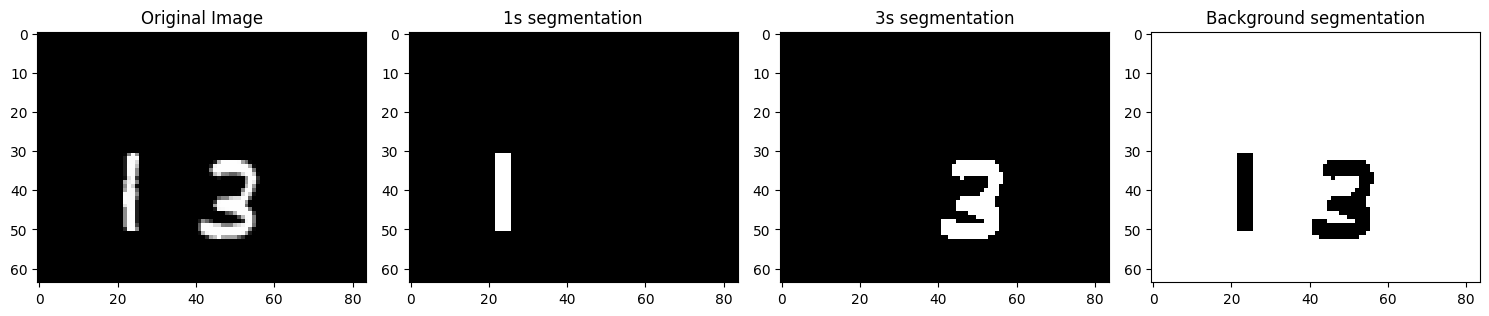

In [4]:
import numpy as np

example = 6

sevens_channel = np.rot90(np.transpose(segmented[example, 1, :, :], (1, 0)))  # access channel for 7 segmentation
fours_channel = np.rot90(np.transpose(segmented[example, 3, :, :], (1, 0)))  # access channel for 4 segmentation
background_channel = np.rot90(np.transpose(segmented[example, 10, :, :], (1, 0)))  # access channel for background segmentation
original_image = np.rot90(np.transpose(combined[example, 0, :, :], (1, 0)))  # original image

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))

ax1.set_title("Original Image")
ax1.imshow(original_image, cmap="gray")
ax2.set_title("1s segmentation")
ax2.imshow(sevens_channel, cmap="gray")
ax3.set_title("3s segmentation")
ax3.imshow(fours_channel, cmap="gray")
ax4.set_title("Background segmentation")
ax4.imshow(background_channel, cmap="gray")

plt.tight_layout()
plt.show()


Before we train any model, we will split out data using sklearn train_test_split

In [6]:
train_examples, test_examples, train_targets, test_targets = train_test_split(combined, segmented, test_size=0.2)

print("train_examples shape: ", train_examples.shape)
print("train_targets shape: ", train_targets.shape)
print("test_examples shape: ", test_examples.shape)
print("test_targets shape: ", test_targets.shape)

train_examples shape:  (4000, 1, 64, 84)
train_targets shape:  (4000, 11, 64, 84)
test_examples shape:  (1000, 1, 64, 84)
test_targets shape:  (1000, 11, 64, 84)


The below function creates a plot of all filter maps from an example from the test set. We will use it for comparing the progress of our model against the test set. Due to the generative nature of this task, although it is classifcation, it is difficult to judge the performance of the model based on training metrics alone. This is the reason I did not include accuracy as a trianing metric.

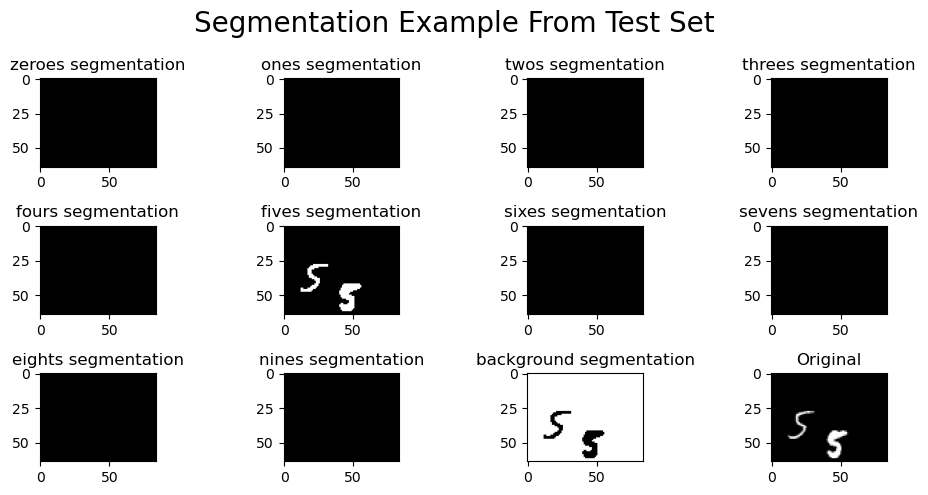

In [7]:
def plot_segmentations(segmented_image, original_image, title):
    '''
    input is 3d tensor to plot with shape (11, 64, 84)
    '''

    fig, axes = plt.subplots(3, 4, figsize=(10, 5))  # get a 3x4 grid of Axes
    axes = axes.flatten()  # make it into a 1-dimensional array for easier handling

    supertitle = fig.suptitle(title, fontsize=20)  # add a centered title to the figure

    fig_title = [
        "zeroes segmentation",
        "ones segmentation",
        "twos segmentation",
        "threes segmentation",
        "fours segmentation",
        "fives segmentation",
        "sixes segmentation",
        "sevens segmentation",
        "eights segmentation",
        "nines segmentation",
        "background segmentation", 
        "Original",  
    ]

    for i in range(11):  # loop over all 11 channels
        segmentation_channel = segmented_image[i, :, :]  
        axes[i].imshow(segmentation_channel, cmap="gray")  # show the channel as an image
        axes[i].set_title(fig_title[i])  # set the title for the subplot

    # Plot original image in the last subplot
    original_image_plotted = original_image.reshape(64, 84)
    axes[11].imshow(original_image_plotted, cmap="gray")
    axes[11].set_title(fig_title[11])

    plt.tight_layout()
    plt.show()


example = 6
segmented_image = test_targets[example, :, :, :]
original_image = test_examples[example, :, :, :]
title = "Segmentation Example From Test Set"
plot_segmentations(segmented_image, original_image, title)


# Model 1 -- quick implementation to gain training insights

In this project, we will be training a convolutional neural network to take an original image and output a (64, 84, 11) tensor that contains the segmentation masks for each digit and the background. 

Traditional convolutional networks work by downsampling the pixel size of an image while upsampling the number of channels/feature maps it contains assuming the stride (amount of movement of the receptive field during convolution) is above one. This presents a problem with regards to using CNNs to do image segmentation. The output of an image segmentation CNN must maintain the spatial dimmensions of the input while adjusting the channel dimmensions for segmentation. If we were to use a traditional CNN that purely downsamples, we would not achieve this end.

To cut through this problem, we can use Conv2DTranspose and UpSampling layers to counteract whatever downsampling has occured. Conv2DTranspose layers are often stated to have fractional stride. Which means that as the receptive field scans the image, it moves by a fraction of a pixel allowing upsampling of the image. 

With this in mind, we can discuss the task of classification. The task is to classify every pixel in each 64x84 image to one of the 11 classes. In traditional CNN style, classication is done by reducing dimmensionality enough with conv layers to the point where the image data can be fed into a Dense layer, to which the dense layer will output the final classification. Because we wish to preserve spatial dimmensionality, we cant use this metthod. Instead, we are going to use conv layers for our output as well. Not only does it fix any dimmensionality issues that the dense layer mgiht cuase, but it also will reduce computational complexity of the model as a whole. All layers of our net will be convolutional, making it a Fully Convolution Network (FCN).

The architecture of this model starts with the input layers, here the input image is reshaped to a channel first image (1, 64, 84) as opposed to a channel first image (64, 84, 1). This is because we are using GPU cloud computing to train the model and channel first is better optimized for GPU support. The model has an encoder and decoder section within the architecture. The (1, 64, 84) tensor is input and and downsampled into a latent represenation using two convolutional blocks. The result is a 64 filter compression that will then be upsampled to an (11, 64, 84) in the decoder section. 

Leaky relu is our activation. 20% dropout is used after maxpooling layers

In [6]:
segmenter = keras.models.Sequential([

    #define input shape
    keras.layers.Input(shape=(1, 64, 84)),

    #downsampling/encoding
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),

    #upsampling/decoding
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=11, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.Activation("sigmoid")
])

segmenter.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy')
segmenter.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 64, 84)        160       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 64, 84)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 42)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 42)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 32, 42)        8256      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 32, 42)        0         
                                                      

I will only train the model for 100 epochs to get a quick sense for how much to scale up the model. Final Validation Accuracy was 0.016. I have removed the training metric history for the sake of concision when I upload this notebook on GitHub

In [ ]:
history = segmenter.fit(train_examples, train_targets, epochs=100, validation_data=(test_examples, test_targets))

This function plots the learning curves of the current model using loss and val loss as the metric

In [ ]:
def plot_learning_curves(height):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, height)
    plt.show()

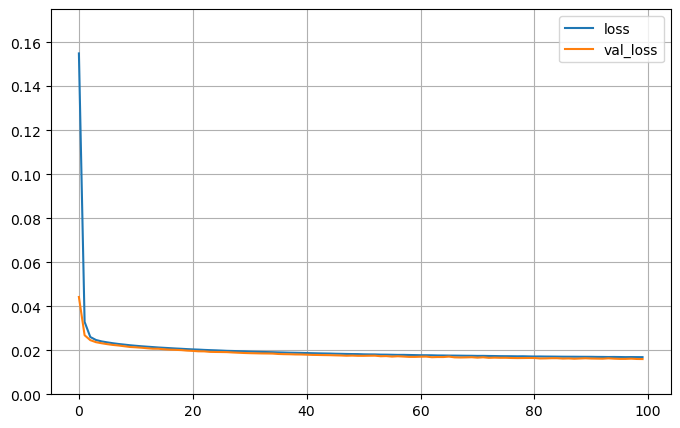

In [20]:
plot_learning_curves(0.175)

The function below plots the current model progress. All models in this notebook are named segmenter so there is no need to adjust it before calling (assuming it is being called after a new model has been trained).

In [ ]:
import random 

def plot_model_prog():   
    # Expand dimensions to 3D tensor to include batch size 
    test_example_6 = np.expand_dims(test_examples[random.randint(0, 1000)], axis=0)
    segment_pred = segmenter.predict(test_example_6)
    # Squeeze out batch size dimension
    segment_pred = np.squeeze(segment_pred, axis=0)

    # Original image for plotting
    original_image = np.squeeze(test_example_6, axis=0)

    title = "Segmentation Prediction with Example From Test Set"
    plot_segmentations(segment_pred, original_image, title)

1/1 [==============================] - 0s 168ms/step


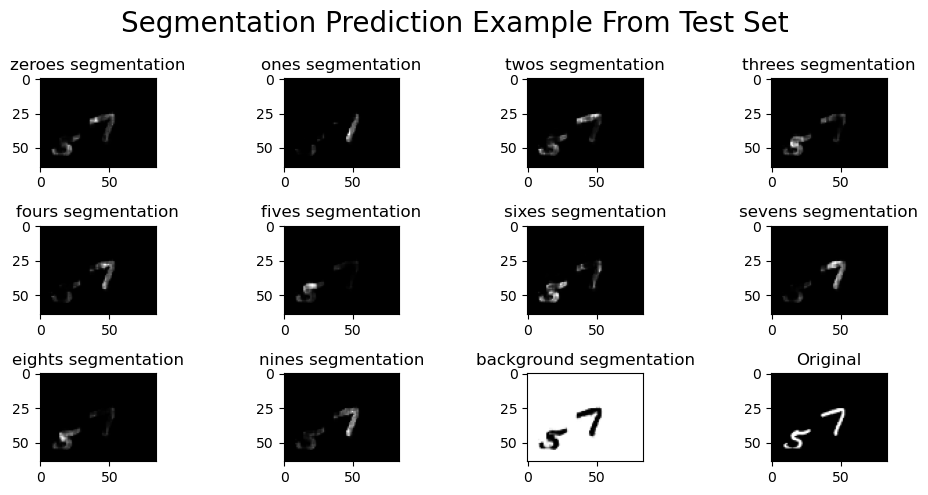

In [24]:
plot_model_prog()

Model 1 has learned some important things about its task. It has gained an understanding that the reducing the training loss has something to do with the white pixels that make up the six and nine. As well that the background is of considerably less interest than those hot spots. We know this because there faint outlines of the digits in each of the 11 feature maps, except for the background segmentation map. It has almost mastered the task of outlining the background with this architecture, nearly all background pixel are labeled correctly.

# Model 2

As opposed to training model 1 until its architecture is optimized, we are going to increase the model complexity to improve the model's comprehension of the task. We want to see an emphasis in the white pixels in the correct feature maps. The only difference from this model to the last is that we have doubled the parameters by doubling up the original conv layers. All else is the same.

In [25]:
segmenter = keras.models.Sequential([

    #define input shape
    keras.layers.Input(shape=(1, 64, 84)),

    #downsampling/encoding
    
    #downsampling block 1
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),
    
    #dowsampling block 2
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),

    #########
    
    #upsampling/decoding
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    #output block
    keras.layers.Conv2D(filters=11, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.Activation("sigmoid")
])

segmenter.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy')
segmenter.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 64, 84)        160       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 64, 84)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 64, 84)        4128      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 64, 84)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 42)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 42)        0         
                                                      

Again, we are only training for 100 epochs. We are gaining a sense for how much we can increase the weights before the model becomes too unruly to train. Final val loss after 100 epochs was 0.0115 which is a slight imporvement from the last model by -0.0045 

In [ ]:
segmenter.fit(train_examples, train_targets, epochs=100, validation_data=(test_examples, test_targets))

1/1 [==============================] - 0s 19ms/step


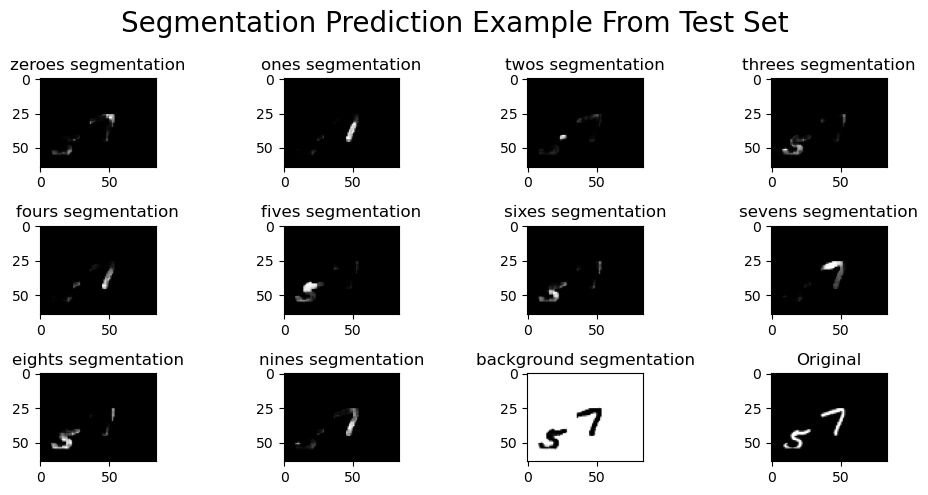

In [29]:
plot_model_prog()

Model 2, after 100 epochs, is placing less emphasis on the incorrect features maps for the digit in question. It is confusing 7 with 1 and 9. It is also confusing 5 with 8 and 6.

# Model 3

We are going to increase the model complexity once more with this new implementaion. One additional conv layer, identical to the other two, has been added to each conv block. 

With this implementaiton, we want to see a further decrease in the amount of subsidiary noise on the incorrect channels. Additionally, we want to see an increase in the white pixel density in the correct channels.

In [30]:
segmenter = keras.models.Sequential([

    #define input shape
    keras.layers.Input(shape=(1, 64, 84)),

    #downsampling/encoding
    
    #downsampling block 1
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
     keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    #pooling
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),
    
    #dowsampling block 2
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    #pooling
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),

    #########
    
    #upsampling/decoding
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.LeakyReLU(alpha=0.2),
    
    #output block
    keras.layers.Conv2D(filters=11, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.Activation("sigmoid")
])

segmenter.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy')
segmenter.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 64, 84)        160       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 64, 84)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 64, 84)        4128      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 64, 84)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 64, 84)        4128      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 64, 84)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 42)      

Since the model is more complex, we are goling to train it for longer to take advantage of the opportunity in those additional weights. Training epochs have been set to 1000 but we are using Early Stopping regularization to cut training short once the val loss has stopped improving. 

Final val accuracy of this implementation was 0.0099

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=13)

history = segmenter.fit(train_examples, train_targets, epochs=1000, validation_data=(test_examples, test_targets), callbacks=[early_stopping])

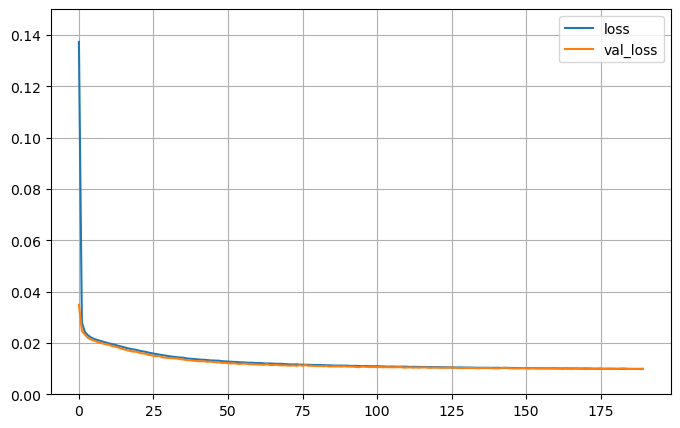

In [34]:
plot_learning_curves(0.15)

1/1 [==============================] - 0s 127ms/step


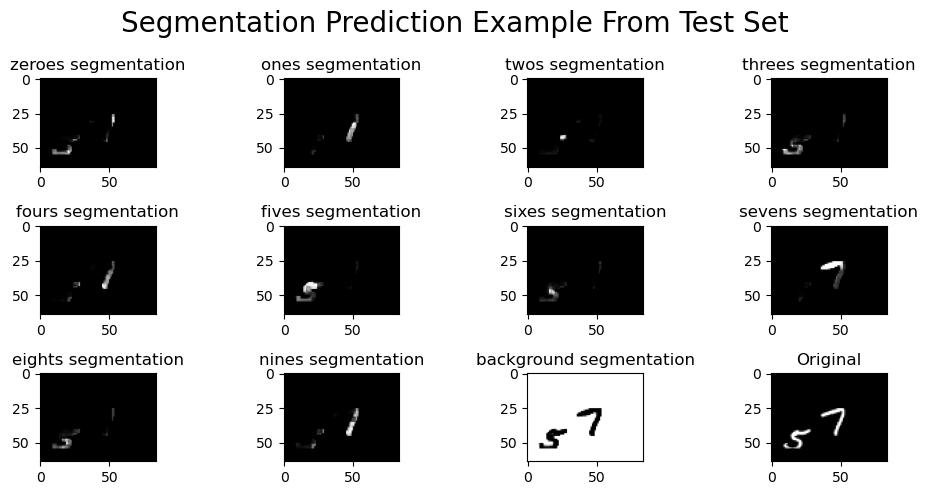

In [35]:
plot_model_prog()

Perfomance appears to be improving in the expected ways. However there is still confusion between similar digits.

# Model 4

This implementation contains batch normalization after each conv later to normalize the input to subsequent layers, leading to more consistentent layers from less need to adapt to large differences in scale between layers. This was added because of the increase in depth to prevent overfitting. 

In [11]:
segmenter = keras.models.Sequential([

    #define input shape
    keras.layers.Input(shape=(1, 64, 84)),

    #downsampling/encoding
    
    #downsampling block 1
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #pooling
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),
    
    #dowsampling block 2
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #pooling
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),

    #########
    
    #upsampling/decoding
    
    #upsample block 1
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #upsample block 2
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #output block
    keras.layers.Conv2D(filters=11, kernel_size=(2, 2), padding="same", data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("sigmoid")
])

segmenter.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy')
segmenter.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 64, 84)        160       
                                                                 
 batch_normalization_13 (Bat  (None, 32, 64, 84)       336       
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 64, 84)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 64, 84)        4128      
                                                                 
 batch_normalization_14 (Bat  (None, 32, 64, 84)       336       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 64, 84)       

Final Accuracy of this implementation was: 0.0091

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12)

history = segmenter.fit(train_examples, train_targets, epochs=1000, validation_data=(test_examples, test_targets), callbacks=[early_stopping])

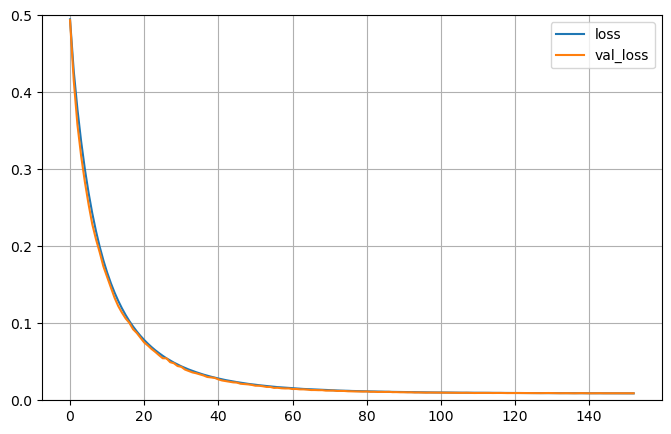

In [16]:
plot_learning_curves(0.5)

1/1 [==============================] - 0s 380ms/step


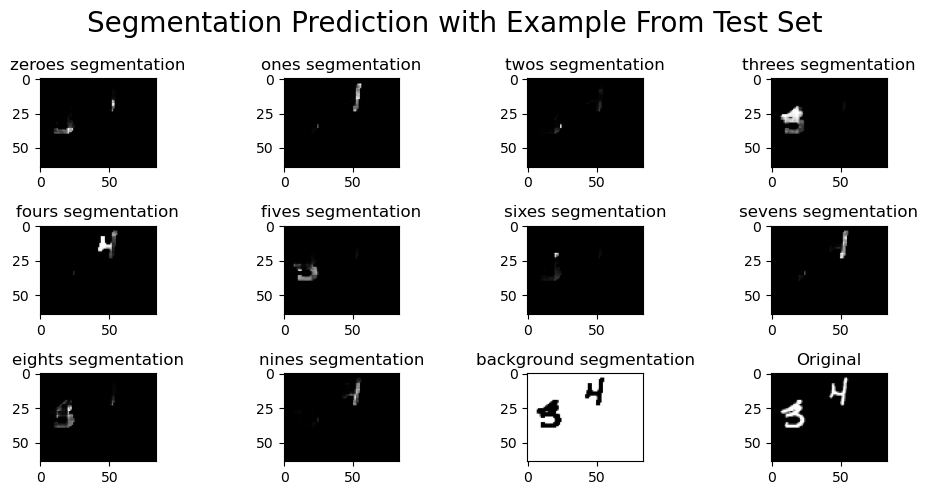

In [17]:
plot_model_prog()

# Model 5 Further Scaling

With batch norm, we can push the depth of the model further with less fear of overfitting. We will again increase the number of conv layers by one at each block. Additionally: the number of filter maps have increase as well. This is the first increase in filter maps and which results in a very large increase in parameters.  72,000 --> 382,000

In [14]:
segmenter = keras.models.Sequential([

    #define input shape
    keras.layers.Input(shape=(1, 64, 84)),

    #downsampling/encoding
    
    #downsampling block 1
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #pooling
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),
    
    #dowsampling block 2
    keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #pooling
    keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
    keras.layers.Dropout(0.2),

    #########
    
    #upsampling/decoding
    
    #upsample block 1
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #upsample block 2
    keras.layers.UpSampling2D(size=(2, 2), data_format='channels_first'),
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    keras.layers.Conv2D(filters=16, kernel_size=(2, 2), padding="same", data_format='channels_first'), 
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    
    #output block
    keras.layers.Conv2D(filters=11, kernel_size=(2, 2), padding="same", data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("sigmoid")
])

segmenter.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.0003), loss='binary_crossentropy')
segmenter.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 64, 64, 84)        320       
                                                                 
 batch_normalization_34 (Bat  (None, 64, 64, 84)       336       
 chNormalization)                                                
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 64, 64, 84)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 84)        16448     
                                                                 
 batch_normalization_35 (Bat  (None, 64, 64, 84)       336       
 chNormalization)                                                
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 64, 64, 84)       

Final Val Loss: 0.0106

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=13)

history = segmenter.fit(train_examples, train_targets, epochs=1000, validation_data=(test_examples, test_targets), callbacks=[early_stopping])

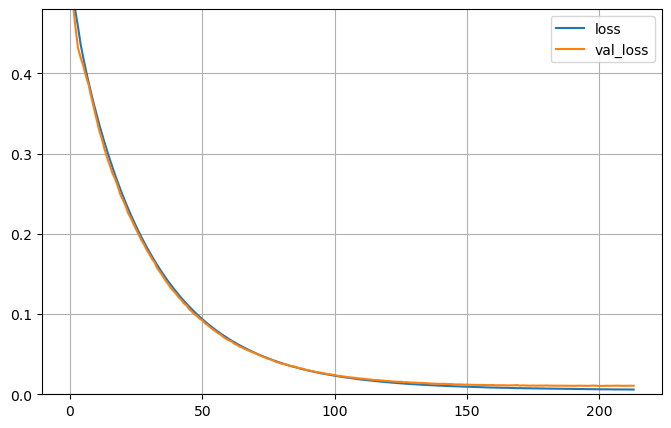

In [16]:
plot_learning_curves(0.5474)

1/1 [==============================] - 0s 301ms/step


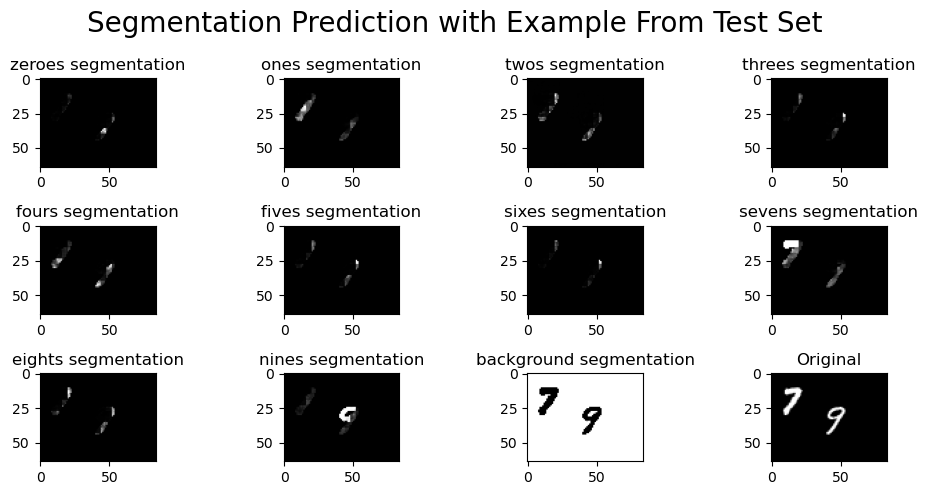

In [17]:
plot_model_prog()

# Model 6

The previous model, despite its many parameters, is still is not sophisticated enough to learn the task. The issue does not appear to be overfitting. The learning curves confirm that the val loss and the training loss are not diverging from each other. This suggests to me that the issue is still underfitting. 

In responce to this, we are going to increase parameters again. From 380,000 --> 2.62 million

For the sake of concision I have switched from a sequential model to the functional API. It is still a feed forward model, however. 

In addition to going deeper, we have also increased the amount of filter maps. There are now three convolutional blocks, each containing 4 convolutional layers. Max pooling follows covolutional blocks in the encoder. Images fed into the decoder go from (1, 64, 84) --> (256, 8, 10) This is a much deeper compression than the precious endocer section in model 5. This provides much more room for the model to extrect patterns from the input and refine them in that depth. 

The decoder also contains 3 conv blocks with four conv layers each. Upscaling is done with Upsampling2D layers with the size of the upsample being 2x2. Because pixels are discrete, the final downsampling layers changed a (256, 16, 21) image into a (256, 8, 10) image, rounding down the 10.5 in the width column. Because of this, there is a final reshape of the output image from (11, 64, 80) --> (11, 64, 84)

In [20]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Dropout, UpSampling2D, Activation, Cropping2D

# Function for convolution and downsampling
def conv_dowsampling_block(gen, filter_size):
    gen = Conv2D(filters=filter_size, kernel_size=(2, 2), padding="same", data_format='channels_first')(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    return gen

# Function for pooling
def pooling_block(gen):
    gen = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(gen)
    gen = Dropout(0.25)(gen)
    return gen

#####

# Input layer
inputs = Input(shape=(1, 64, 84))  # Output Shape: (1, 64, 84)

#####

# Conv block 1
for i in range(4):
    gen = conv_dowsampling_block(inputs, filter_size=64)  # Output Shape: (64, 64, 84)
gen = pooling_block(gen)  # Output Shape: (64, 32, 42)

# Downsampling block 2
for i in range(4):
    gen = conv_dowsampling_block(gen, filter_size=128)  # Output Shape: (128, 32, 42)
gen = pooling_block(gen)  # Output Shape: (128, 16, 21)

# Downsampling block 3
for i in range(4):
    gen = conv_dowsampling_block(gen, filter_size=256)  # Output Shape: (256, 16, 21)
gen = pooling_block(gen)  # Output Shape: (256, 8, 10)

#####

#Upsample block 1
for i in range(4):
    gen = conv_dowsampling_block(gen, filter_size=256)  # Output Shape: (256, 8, 10)
gen = UpSampling2D(size=(2, 2), data_format='channels_first')(gen)  # Output Shape: (256, 16, 20)

# Upsample block 2
for i in range(4):
    gen = conv_dowsampling_block(gen, filter_size=128)  # Output Shape: (128, 16, 20)
gen = UpSampling2D(size=(2, 2), data_format='channels_first')(gen)  # Output Shape: (128, 32, 40)

# Upsample block 3
for i in range(4):
    gen = conv_dowsampling_block(gen, filter_size=64)  # Output Shape: (64, 32, 40)
gen = UpSampling2D(size=(2, 2), data_format='channels_first')(gen)  # Output Shape: (64, 64, 80)

#####

# Adjustments for matching desired output shape
for i in range(2):
    gen = conv_dowsampling_block(gen, filter_size=32)  # Output Shape: (32, 64, 80)
for i in range(2):
    gen = conv_dowsampling_block(gen, filter_size=16)  # Output Shape: (16, 64, 80)
    
# Output block
gen = Conv2D(filters=11, kernel_size=(2, 2), padding="same", data_format='channels_first')(gen)  # Output Shape: (11, 64, 80)

# Add padding after the last convolution layer (11, 64, 80) --> (11, 64, 84)
paddings = tf.constant([[0, 0], [0, 0], [0, 0], [0, 4]])
last_layer_padded = tf.pad(gen, paddings, "CONSTANT")


gen = BatchNormalization()(last_layer_padded)
outputs = Activation("sigmoid")(gen)

# Create model
segmenter = Model(inputs, outputs)

segmenter.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.00004), loss='binary_crossentropy')
segmenter.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 64, 84)]       0         
                                                                 
 conv2d_119 (Conv2D)         (None, 64, 64, 84)        320       
                                                                 
 batch_normalization_118 (Ba  (None, 64, 64, 84)       336       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_115 (LeakyReLU)  (None, 64, 64, 84)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 32, 42)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64, 32, 42)        0   

Final val loss 0.0356

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

history = segmenter.fit(train_examples, train_targets, epochs=1000, validation_data=(test_examples, test_targets), callbacks=[early_stopping])

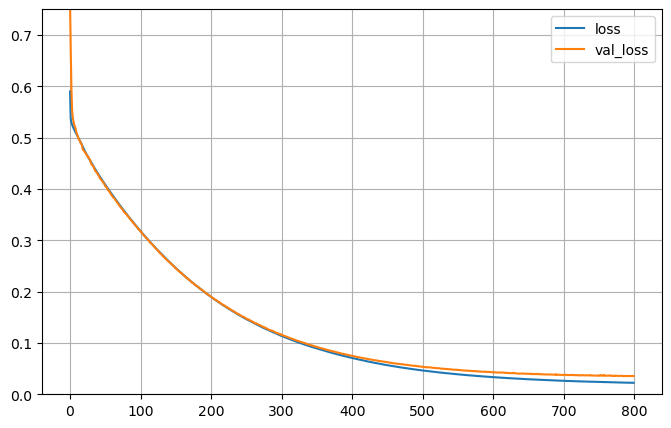

In [23]:
plot_learning_curves(0.75)

1/1 [==============================] - 0s 21ms/step


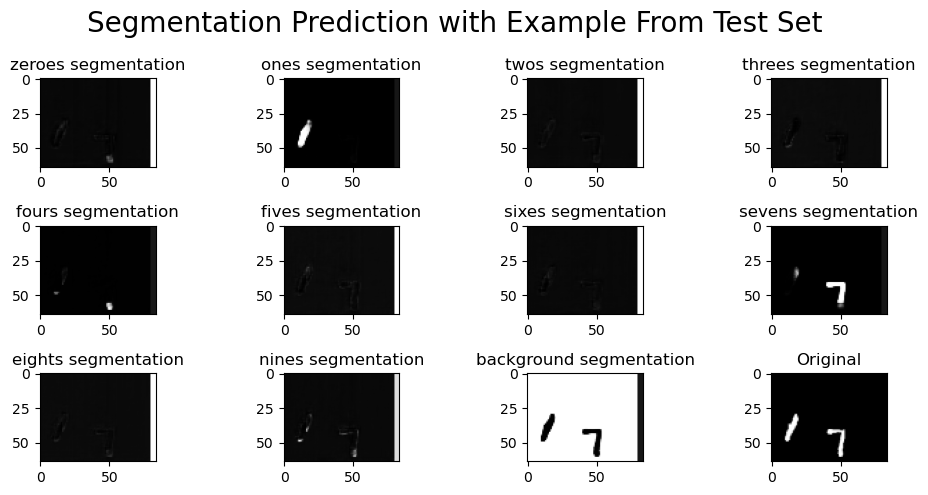

In [44]:
plot_model_prog()

1/1 [==============================] - 0s 21ms/step


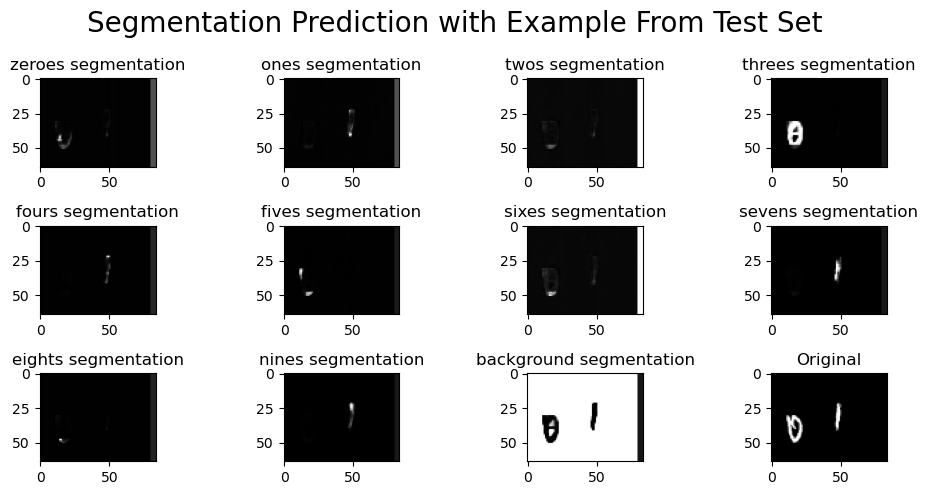

In [50]:
plot_model_prog()

1/1 [==============================] - 0s 20ms/step


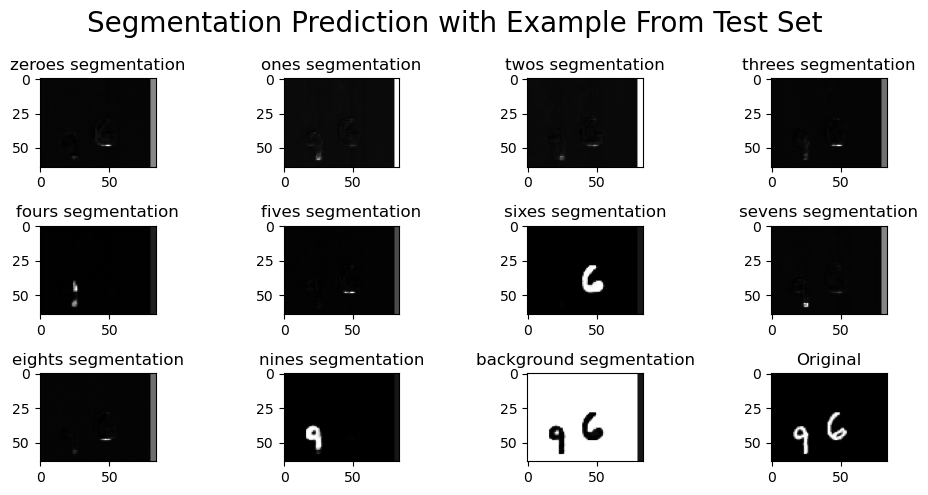

In [54]:
plot_model_prog()

The above plots show the main issues with model 6. Although it is able to correctly perform the task most of the time, at least based on visual inspection, it often confused similar looking digits and still leaves residual white spots on the innapropriate channels. 

This is the best perfomance so far, although it still has many issues. I am going to retire this project here for the time being. And will come back to it in the future to update the model architecture and improve performance.